# Lab 6 CNNS

### Eli Laird

## Introduction

It is estimated that 23,820 adults in the United States will be diagnosed with brain cancer in 2019. Brain and central nervous system cancer is the tenth leading cause of death for men and women in the United States. The 5-year survival rate for men and women with brain cancer is estimated to be between 34 and 36 percent [1]. Early detection of brain tumors is critical in effectively treating patients with brain tumors. In this lab, we will investigate methods for detecting brain tumors using deep Convolutional Neural Networks and Magnetic Resonance Imaging (MRI).

## Business Understanding


##### **Motivation**

The ability to detect and treat a low-grade glioma, today, before it progresses to Glioblastoma multiforme, i.e. brain cancer, can be the difference between life and death [2]. In the past decade, advancements in medical imaging have greatly improved the ability of doctors to diagnose brain tumors without performing exploratory surgery. Exploratory surgery is invasive and introduces many risks to the patient. Magnetic Resonance Imaging, MRI, and Computer-Assisted Tools, CAT scans, are some of the most popular medical imaging techniques used to diagnose brain tumors. These imaging techniques are also used in tumor segmentation and operation planning to provide precision and diagnosis consistency. Using Deep Learning to assist in the diagnosing process can improve the precision of a diagnosis by a considerable amount. In a study of brain tumor diagnosis by the Royal College of Physicians, 10% of patients, in a Scottish audit, had negative CT scans, i.e. a false negative claiming there were no signs of a brain tumor when in fact a brain tumor existed [3]. A negative scan can prove to be fatal as the undetected tumor grows to a higher grade state and will eventually spread to an unrecoverable state. Using Deep Learning to assist in brain tumor diagnosis aims to alleviate this problem by combining the abilities of Convolutional Neural Networks and the domain knowledge of general practictioners to increase the reliability of diagnosing brain tumors. 

##### **Solution**

Convolutional Neural Networks (CNNs) work by applying layers of convolutions to an image to learn specific features of that image. These convolutions apply various filters over the image that correspond to these specific features. For example, a certain filter can be trained to highlight sharp edges in the image, other filters can be learned to focuss on faces or in our case brain tumors. Our Deep Learning solution to early brain tumor detection includes feeding MRI brain scans through different convolutional neural network architectures. Each of these architectures will learn the features of the images and will identify brain scans in which a tumor exists. This solution will allow doctors to make more reliable decisions when  diagnosing a patient with a brain tumor. This solution is not designed to diagnose patients without the assistance of the doctor, however. This solution is designed to provide the doctor with more precise information for the diagnosis and thus act as an aid in order to prevent the scenario where a tumor goes undetected.

##### **Evaluation**

As mentioned before, when diagnosing patients with brain cancer, we want to minimize the amount of undetected brain tumors. This corresponds to having a low false negative rate. Having a low false negative rate is important because a diagnosis that states a patient is cancer free when the patient actually has cancer, that patient will go untreated and the cancer has a higher chance of being fatal. We also do not want to diagnose healthy patients with cancer when they are cancer free because the patient will then go through immense amounts of stress and maybe even go through unnecessary treatment. While false positives are clearly not beneficial to the patient, in the end we consider a false negative more of a detrimental cost because it involves failing to save a life. For this reason we will use the recall metric in evaluating our CNN solution. The recall metric is the ratio of correctly predicted positive observations to all observations of the class. Recall places an emphasis on minimizing false negatives and thus proves to be the most appropriate metric to evaluate our solution. Recall is defined as:

$$
\begin{align}
Recall = \frac{True Positives}{True Positives + False Negatives}
\end{align}
$$



## Data Preparation

In [224]:
import pandas as pd
import numpy as np
%matplotlib inline 
from matplotlib import pyplot as plt
import cv2
import os

In [225]:
file_path = './Brain-Tumor-Images-Dataset/full-data/'

hem_images_dir = os.listdir(file_path + 'hemmorhage_data/')
nonhem_images_dir = os.listdir(file_path + 'non_hemmorhage_data/')

hemmorhage_imgs = []
nonhemmorhage_imgs = []
labels = []
h, w = (250, 150)

#read in hemmorhage images
error_count = 0
for img in hem_images_dir:
    image = cv2.imread(file_path + 'hemmorhage_data/' + img, cv2.IMREAD_GRAYSCALE) 
    image = cv2.resize(image, (150, 250))
    try:
        hemmorhage_imgs.append(image.flatten())
        labels.append(1)
    except:
        error_count += 1
    
#read in nonhemmorage data
for img in nonhem_images_dir:
    image = cv2.imread(file_path + 'non_hemmorhage_data/' + img, cv2.IMREAD_GRAYSCALE) 
    image = cv2.resize(image, (150, 250))
    try:
        nonhemmorhage_imgs.append(image.flatten())
        labels.append(0)
    except:
        error_count += 1
        
        
data = hemmorhage_imgs + nonhemmorhage_imgs
data = np.array(data)
labels = np.array(labels)

#shuffle data
rstate = np.random.get_state()
np.random.shuffle(data)
np.random.set_state(rstate)
np.random.shuffle(labels)

print("{} Images failed to read".format(error_count))
print("Image size:", data[0].shape)
print("Image count:", len(data))

0 Images failed to read
Image size: (37500,)
Image count: 200


In [226]:
#create new sample data
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=360, # used, Int. Degree range for random rotations.
    width_shift_range=0.1, # used, Float (fraction of total width). Range for random horizontal shifts.
    height_shift_range=0.1, # used,  Float (fraction of total height). Range for random vertical shifts.
    shear_range=0., # Float. Shear Intensity (Shear angle in counter-clockwise direction as radians)
    zoom_range=0.,
    channel_shift_range=0.,
    fill_mode='nearest',
    cval=0.,
    horizontal_flip=True,
    vertical_flip=True,
    rescale=None)

#expand dimensions
data = np.expand_dims(data.reshape((-1, h, w)), axis=3)

datagen.fit(data)

new_hemmorhages = datagen.flow(data, labels, batch_size=1000)

In [227]:
i = 0
for tmp in new_hemmorhages:
    if i == 1000: break
    i = i+1
    if i % 50 == 0: print("{} images added".format(i))
    #plt.imshow(tmp[0][0].squeeze(),cmap='bone')
    #plt.title(tmp[1][0])
    data = np.vstack((data,np.expand_dims(tmp[0][0].squeeze().reshape((-1,h,w)), axis=3)))
    labels = np.append(labels,tmp[1][0])
    

50 images added
100 images added
150 images added
200 images added


KeyboardInterrupt: 

In [217]:
labels.shape

(298,)

In [93]:
# select random images to visualize
import random
random.seed(1)

# function to plot images in grid like fashion
def plot_gallery(images, title, h, w, n_row=3, n_col=6):
    plt.figure(figsize=(1.7 * n_col, 2.3 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    rand_sample = random.sample(range(0,images.shape[0]), k=18)
    for n,i in enumerate(rand_sample):
        plt.subplot(n_row, n_col, n + 1)
        plt.imshow(images[i].reshape((h,w)))
        plt.title(title[i], size=12)
        plt.xticks(())
        plt.yticks(())

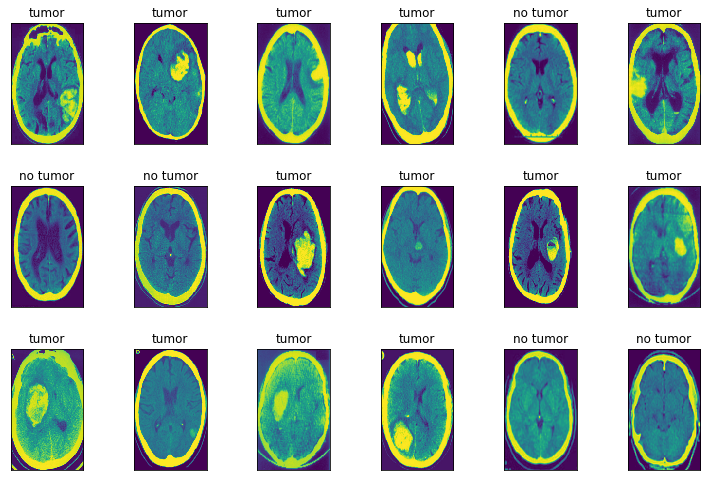

In [106]:
# plot random images
plot_gallery(data, labels, h,w)

In [119]:
from keras.preprocessing.image import ImageDataGenerator

data.shape

(200, 37500)

## References


* [1] https://www.cancer.net/cancer-types/brain-tumor/statistics
* [2] https://weillcornellbrainandspine.org/early-detection-can-be-key-surviving-brain-tumor
* [3] https://jnnp.bmj.com/content/75/suppl_2/ii18